In [ ]:
import numpy as np
import json
import yaml
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib.colors import LogNorm
import py_sc_fermi
from py_sc_fermi.defect_charge_state import DefectChargeState
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.defect_system import DefectSystem
from pymatgen.core import Structure
from pydefect.chem_pot_diag.chem_pot_diag import ChemPotDiagMaker, RelativeEnergies, CpdAbstractEnergies
from pydefect.chem_pot_diag.cpd_plotter import ChemPotDiag3DMplPlotter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from vise.util.sort_coords import sort_coords
from pydefect.analyzer.defect_energy import DefectEnergy, DefectEnergies, DefectEnergySummary
from pydefect.analyzer.defect_energy_plotter import DefectEnergyMplPlotter

In [ ]:
folder_ = './GaAs/unitcell/structure_opt/'
dos_vasp = py_sc_fermi.dos.DOS.from_vasprun(folder_ + '/vasprun.xml', 18)
structure = Structure.from_file(folder_ + 'CONTCAR')
volume = structure.volume

def defect_concentration(states, temp=1513, f_level=None, print_intrinsic=None):
    c1, c2, c3 = states
    charge_1, formation_1 = c1
    charge_2, formation_2 = c2
    charge_3, formation_3 = c3

    As_Ga_0 = DefectChargeState(charge=charge_1, degeneracy=2, energy=formation_1)
    As_Ga_p_1 = DefectChargeState(charge=charge_2, degeneracy=2, energy=formation_2)
    As_Ga_p_2 = DefectChargeState(charge=charge_3, degeneracy=2, energy=formation_3)

    As_Ga = DefectSpecies(name="As_Ga", nsites=2,  charge_states={charge_1:As_Ga_0, charge_2:As_Ga_p_1, charge_3:As_Ga_p_2})
    defect_system = DefectSystem(defect_species=[As_Ga], dos=dos_vasp, volume=volume, temperature=temp)

    intrinsic_fermi_energy = defect_system.get_sc_fermi()[0]

    if print_intrinsic:
        p0 = dos_vasp.carrier_concentrations(intrinsic_fermi_energy, 1000)[0] * 1e24 / defect_system.volume
        n0 = dos_vasp.carrier_concentrations(intrinsic_fermi_energy, 1000)[1] * 1e24 / defect_system.volume

        print(n0, p0)


    if f_level == None:
        conc = As_Ga.get_concentration(e_fermi=intrinsic_fermi_energy, temperature=temp) * 1e24 / defect_system.volume

    else:
        conc = As_Ga.get_concentration(e_fermi=f_level, temperature=temp) * 1e24 / defect_system.volume

    return conc

defect_concentration([(0, 3.460532627500013), (1, 3.4150580842731952), (2, 3.721131361951184)])

262168613685.60565

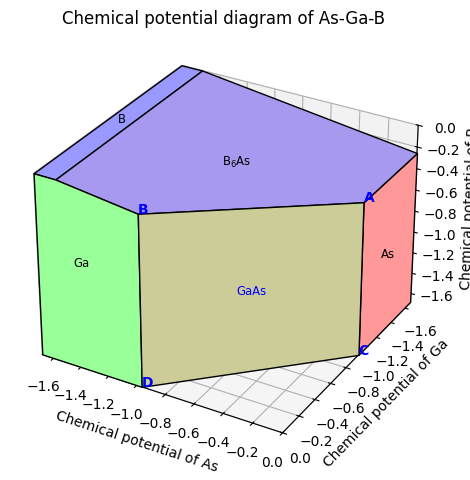

In [ ]:
target_vertices_yaml = "../cpd/target_vertices.yaml"
relative_energies_yaml = "../cpd/relative_energies.yaml"
standard_energies_yaml = "../cpd/standard_energies.yaml"

with open(target_vertices_yaml) as stream:
    target_vertices_data = yaml.safe_load(stream)
with open(relative_energies_yaml) as stream:
    relative_energies_data = yaml.safe_load(stream)
with open(standard_energies_yaml) as stream:
    standard_energies_data = yaml.safe_load(stream)

cpd_3d = ChemPotDiagMaker(relative_energies=RelativeEnergies(CpdAbstractEnergies(relative_energies_data)), 
                 elements=["As", "Ga", "B"], target="GaAs").chem_pot_diag

class mod_ChemPotDiag3DMplPlotter(ChemPotDiag3DMplPlotter):
    def draw_simplex(self, formula):

        vertex_coords = self.cpd.polygons[formula]


        face = Poly3DCollection([sort_coords(np.array(vertex_coords))])
        
        if formula == "GaAs":
            face.set_cmap('jet')
        else:
            face.set_color([1, 1, 1])

        face.set_edgecolor("black")
        self._ax.add_collection3d(face)

plotter = ChemPotDiag3DMplPlotter(cpd_3d)
plotter.draw_diagram().show()


In [ ]:
f = open('defect_energy_summary.json')
data = json.load(f)

def json_to_object(json_dict):
    def convert_defect_energy(de):
        return DefectEnergy(
            formation_energy=de["formation_energy"],
            energy_corrections=de["energy_corrections"],
            is_shallow=de["is_shallow"]
        )

    def convert_defect_energies(de):
        return DefectEnergies(
            atom_io=de["atom_io"],
            charges=de["charges"],
            defect_energies=[convert_defect_energy(e) for e in de["defect_energies"]]
        )

    return DefectEnergySummary(
        title=json_dict["title"],
        defect_energies={key: convert_defect_energies(val) for key, val in json_dict["defect_energies"].items()},
        rel_chem_pots=json_dict["rel_chem_pots"],
        cbm=json_dict["cbm"],
        supercell_vbm=json_dict["supercell_vbm"],
        supercell_cbm=json_dict["supercell_cbm"]
    )

defect_energy_summary = json_to_object(data)


   INFO: -- Settings from vise.yaml:
   INFO: 
   INFO: -- Settings from pydefect.yaml:
   INFO: 


In [ ]:
def get_conc_at_fermi(defect_energy_summary_object, x, y, z, defect_id='As_Ga', x_id='As', y_id='Ga', z_id='B'):
    defect_energy_summary_object.rel_chem_pots["A-temp"] = {x_id: x, y_id: y, z_id: z}
    f = defect_energy_summary_object.charge_energies("A-temp", True, True, (0, defect_energy_summary_object.cbm))
    f = f.charge_energies_dict[defect_id].charge_energies_at_ef(0)

    dn = 1e14
    p = 1.132e6
    c_tot = 3e-10
    
    return (c_tot) * defect_concentration(f, temp=1513, f_level=None) * (dn + p)

get_conc_at_fermi(defect_energy_summary, -0.5, 0, 0)

3.911231170992156e+17

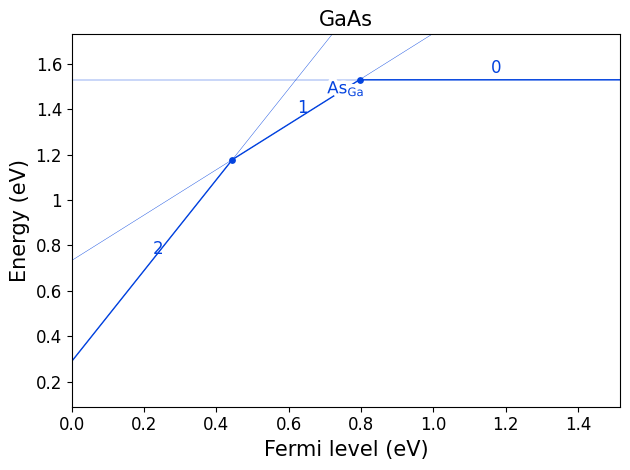

In [10]:
plotter = DefectEnergyMplPlotter(
    defect_energy_summary=defect_energy_summary,
    chem_pot_label="A",
    allow_shallow=True,
    with_corrections=True,
    add_thin_lines=True)
plotter.construct_plot()
plotter.plt.show()

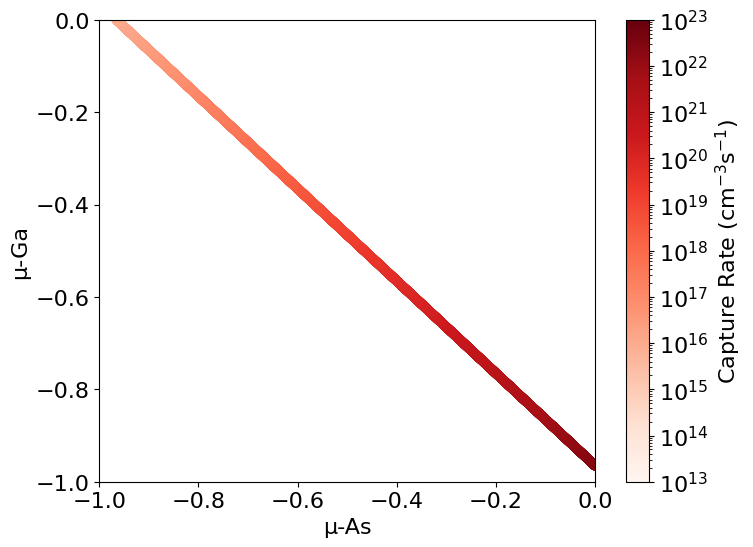

In [ ]:
plt.figure()
plt.rcParams.update({'font.size': 16, 'figure.figsize': (8, 6)})
plt.rcParams['font.family'] = 'sans-serif'

x = np.linspace(*np.array(cpd_3d.polygons['GaAs'])[:2, 0], 10000)
y = np.linspace(*np.array(cpd_3d.polygons['GaAs'])[:2, 1], 10000)

efermi = 0.7

comb = [[xi, yi, get_conc_at_fermi(defect_energy_summary, xi, yi, 0)] for xi, yi in zip(x, y)]
comb = np.array(comb)

x = comb[:, 0]
y = comb[:, 1]
c = comb[:, 2]
sc = plt.scatter(x, y, c=c, norm=LogNorm(vmin=1e13, vmax=1e23), cmap='Reds')


cbar = plt.colorbar(sc, label='Capture Rate ($\mathsf{cm^\mathsf{-3}}$$\mathsf{s^\mathsf{-1}}$)')
cbar.minorticks_on()
cbar.ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=30))
cbar.ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='all', numticks=10))

plt.xlim(right=0, left=-1)
plt.ylim(top=0, bottom=-1)

plt.xlabel('µ-As')
plt.ylabel('µ-Ga')

plt.savefig('As_Ga_formation_custom1.svg', format='svg', transparent=True)
